In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys

# 改为你的仓库名，如果你是用git clone的默认名就是这个
project_path = "/content/drive/MyDrive/Neur2RO"
os.chdir(project_path)  # 切换到项目根目录

# 加入PYTHONPATH，让Python能找到 ro.scripts.*
if project_path not in sys.path:
    sys.path.insert(0, project_path)


In [4]:
import matplotlib.pyplot as plt, sys, site, os
import scienceplots  # 确保已安装
import inspect
sp_dir = os.path.dirname(inspect.getfile(scienceplots))
style_path = os.path.join(sp_dir, 'styles', 'science.mplstyle')
plt.style.use([style_path])  # 或 [style_path, os.path.join(sp_dir,'styles','no-latex.mplstyle')]


In [5]:
import os
import time
import copy
import collections
import scipy as sp
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt, sys, site, os
import scienceplots  # 确保已安装
import inspect
sp_dir = os.path.dirname(inspect.getfile(scienceplots))
style_path = os.path.join(sp_dir, 'styles', 'science.mplstyle')
plt.style.use([style_path])  # 或 [style_path, os.path.join(sp_dir,'styles','no-latex.mplstyle')]

In [6]:
import ro.params as ro_params
from ro.utils.kp import get_path

### Functions

In [7]:
def get_results(result_dir, algo_type):
    """ Gets results for specific algorithm type from specified directory.  """
    opt_type, obj_type = algo_type.split("-")

    # filter files for files for algorithm type
    files = os.listdir(result_dir)
    files = list(filter(lambda x: 'results' in x, files))

    # append directory
    files = list(map(lambda x: result_dir + x, files))

    # load results for all files
    results = {}
    for n_items in [20,30,40,50,60,70,80]:
        results[n_items] = []

    for file in files:
        with open(file, 'rb') as p:
            file_res = pkl.load(p)
            n_items = len(file_res['opt_stats']['xi_added']['obj'][0])
            results[n_items].append(file_res)

    return results

In [8]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

In [9]:
def get_inst_agg_results(results, n_items, inst_type, paper_time_limit=3 * 3600.00):
    """  """
    res = list(filter(lambda x: f"_{inst_type}_" in x['inst_name'], results[n_items]))
    # remove empty entries from evaluation not working
    n_no_sol = len(list(filter(lambda x: x['algo_obj'] is None, res)))
    res = list(filter(lambda x: x['algo_obj'] is not None, res))

    # gap between baseline and algo
    gap = list(map(lambda x: 100 * (x['baseline_obj'] - x['algo_obj'])/x['baseline_obj'], res))
    gap_mean = np.mean(gap)

    # get best known sol
    best_obj = []
    for i in range(len(res)):
        best_obj.append(max(res[i]['baseline_obj'], res[i]['algo_obj']))

    re_ml = list(map(lambda x, y: 100 * abs(y - x['algo_obj'] )/abs(y), res, best_obj ))
    re_baseline = list(map(lambda x, y: 100 * abs(y - x['baseline_obj'])/abs(y), res, best_obj ))

    # algorithm time
    time_algo = list(map(lambda x: x['algo_time'], res))
    time_algo_mean = np.mean(time_algo)

    # get baseline time
    time_baseline = list(map(lambda x: x['baseline_time'], res))
    n_limits = len(list(filter(lambda x: x == 'TIME_LIMIT', time_baseline)))

    # replace limit with value, and convert to floats
    time_baseline = list(map(lambda x: paper_time_limit if x == 'TIME_LIMIT' else x, time_baseline))
    time_baseline = list(map(lambda x: float(x), time_baseline))
    time_baseline_mean = np.mean(time_baseline)

    # time ratio
    time_ratio = list(map(lambda x, y: x / y, time_baseline, time_algo))
    time_ratio_mean = np.mean(time_ratio)

    # number of scenarios added
    n_scenarios = np.mean(list(map(lambda x: len(x['opt_stats']['xi_added']['obj']), res)))


    inst_results = {
        "gap" : gap,
        "time_algo" : time_algo,
        "time_baseline" : time_baseline,
        "time_ratio" : time_ratio,

        "n_limits" : n_limits,
        "mean_gap" : gap_mean,
        "mean_time_baseline" : time_baseline_mean,
        "mean_time_algo" : time_algo_mean,

        "re_ml" : re_ml,
        "re_ml_mean" : np.mean(re_ml),
        "re_ml_median" : np.median(re_ml),
        "re_ml_q1" : np.percentile(re_ml, 25),
        "re_ml_q3" : np.percentile(re_ml, 75),
        "re_baseline" : re_baseline,
        "re_baseline_mean" : np.mean(re_baseline),
        "re_baseline_median" : np.median(re_baseline),
        "re_baseline_q1" : np.percentile(re_baseline, 25),
        "re_baseline_q3" : np.percentile(re_baseline, 75),

        'n_scenarios' : n_scenarios,
    }

    return inst_results

In [10]:
def latex_main_results(df_, corr_type):
    """ Generate Latex table for combined results.  """

    df = df_.copy()

    df = df.rename(columns={
        'mre-ml' : '\\method{}',
        'mre-baseline' : 'BP',
        'time-A-AM' : '\\method{}\ ',
        'time-baseline' : 'BP\ ',
       })

    df = df.style.format(thousands=',', formatter =
        {'\\method{}'     : '{:.3f}'.format,
         'BP'             : '{:.3f}'.format,
         '\\method{}\ '   : '{:.0f}'.format,
         'BP\ '           : '{:.0f}'.format,
        })

    df = df.highlight_min(subset=['\\method{}', 'BP'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\method{}\ ', 'BP\ '], props='textbf:--rwrap;', axis=1)

    end_str = '}\n\\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}\n'
    end_str += '\\label{tab:kp_results}\n'
    end_str += '\\end{table*}'

    latex_str = df.to_latex(column_format='l|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, '\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:27: SyntaxWarning: invalid escape sequence '\_'
<>:27: SyntaxWarning: invalid escape sequence '\#'
<>:31: SyntaxWarning: invalid escape sequence '\#'
<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:27: SyntaxWarning: invalid escape sequence '\_'
<>:27: SyntaxWarning: invalid escape sequence '\#'
<>:31: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipython-input-3088484933.py:9: SyntaxWarning: invalid escape sequence '\ '
  't

In [11]:
def get_main_paper_df(results, inst_type, algo_type, tol=5e-4, use_median=True):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = ["mre-ml", "mre-baseline", f"time-{algo_type}", "time-baseline", ]

    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)

        if use_median:
            df["mre-ml"][n_item] = n_item_res['re_ml_median']
            df["mre-baseline"][n_item] = n_item_res['re_baseline_median']
        else:
            df["mre-ml"][n_item] = n_item_res['re_ml_mean']
            df["mre-baseline"][n_item] = n_item_res['re_baseline_mean']

        n_better = np.sum((np.array(n_item_res['gap']) < - tol))
        pct_better = 100 * n_better / len(list(np.array(n_item_res['gap'])))
        df[f"time-{algo_type}"][n_item] = n_item_res['mean_time_algo']
        df["time-baseline"][n_item] = n_item_res['mean_time_baseline']

    return df

In [12]:
def get_main_paper_df_extended(results, inst_type, algo_type, tol=5e-4):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = ["mean-re-ml", "mean-re-baseline",
            "median-re-ml", "median-re-baseline",
            "q1-re-ml", "q1-re-baseline",
            "q3-re-ml", "q3-re-baseline" ]

    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)

        df["mean-re-ml"][n_item] = n_item_res['re_ml_mean']
        df["mean-re-baseline"][n_item] = n_item_res['re_baseline_mean']

        df["median-re-ml"][n_item] = n_item_res['re_ml_median']
        df["median-re-baseline"][n_item] = n_item_res['re_baseline_median']

        df["q1-re-ml"][n_item] = n_item_res['re_ml_q1']
        df["q1-re-baseline"][n_item] = n_item_res['re_baseline_q1']

        df["q3-re-ml"][n_item] = n_item_res['re_ml_q3']
        df["q3-re-baseline"][n_item] = n_item_res['re_baseline_q3']

    return df

In [13]:
def latex_main_results_extended(df_):
    """ Generate Latex table for combined results.  """

    df = df_.copy()

    df = df.style.format(thousands=',', precision=3)

    df = df.highlight_min(subset=['mean-re-ml', 'mean-re-baseline'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['median-re-ml', 'median-re-baseline'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['q1-re-ml', 'q1-re-baseline'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['q3-re-ml', 'q3-re-baseline'], props='textbf:--rwrap;', axis=1)

    end_str = '}\n\\caption{Knapsack: Extended table}\n'
    end_str += '\\label{tab:kp_ext}\n'
    end_str += '\\end{table*}'

    latex_str = df.to_latex(column_format='l|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(3, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

<>:17: SyntaxWarning: invalid escape sequence '\_'
<>:17: SyntaxWarning: invalid escape sequence '\#'
<>:17: SyntaxWarning: invalid escape sequence '\_'
<>:17: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipython-input-3303214302.py:17: SyntaxWarning: invalid escape sequence '\_'
  latex_str = df.to_latex(column_format='l|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')
/tmp/ipython-input-3303214302.py:17: SyntaxWarning: invalid escape sequence '\#'
  latex_str = df.to_latex(column_format='l|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')


## Data Directory

In [14]:
data_dir = '/content/drive/MyDrive/Neur2RO/data/'

In [15]:
problem = 'kp'
cfg = getattr(ro_params, problem)

In [16]:
fp_inst = get_path(data_dir, cfg, "inst")
fp_data = get_path(data_dir, cfg, "ml_data")
fp_nn = get_path(data_dir, cfg, "set_encoder")
fp_nn_res = get_path(data_dir, cfg, "set_encoder_tr_res")

In [17]:
result_dir = data_dir + problem + '/eval_results/'

In [18]:
results = get_results(result_dir, 'A-AM')

# Main paper: Tables

In [19]:
mp_un = get_main_paper_df(results, 'UN', 'A-AM')
mp_wc = get_main_paper_df(results, 'WC', 'A-AM')
mp_asc = get_main_paper_df(results, 'ASC', 'A-AM')
mp_sc = get_main_paper_df(results, 'SC', 'A-AM')

/tmp/ipython-input-2040626909.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["mre-ml"][n_item] = n_item_res['re_ml_median']
/tmp/ipython-input-2040626909.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 

In [20]:
latex_main_results(mp_un, 'UN')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.417 & \textbf{0.000} & 4 & \textbf{0} \\
30 & 1.188 & \textbf{0.000} & 6 & \textbf{1} \\
40 & 1.614 & \textbf{0.000} & 9 & \textbf{3} \\
50 & 1.814 & \textbf{0.000} & \textbf{9} & 12 \\
60 & 1.146 & \textbf{0.000} & \textbf{14} & 18 \\
70 & 1.408 & \textbf{0.000} & \textbf{16} & 46 \\
80 & 0.968 & \textbf{0.000} & \textbf{11} & 388 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



In [21]:
latex_main_results(mp_wc, 'WC')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.582 & \textbf{0.000} & \textbf{5} & 29 \\
30 & 2.236 & \textbf{0.000} & \textbf{11} & 454 \\
40 & 1.595 & \textbf{0.000} & \textbf{20} & 6179 \\
50 & 1.757 & \textbf{0.000} & \textbf{19} & 8465 \\
60 & 0.695 & \textbf{0.000} & \textbf{77} & 9242 \\
70 & 0.165 & \textbf{0.000} & \textbf{15} & 10800 \\
80 & \textbf{0.000} & 0.341 & \textbf{21} & 10800 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



In [22]:
latex_main_results(mp_asc, 'ASC')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.439 & \textbf{0.000} & \textbf{5} & 9 \\
30 & 0.782 & \textbf{0.000} & \textbf{6} & 2708 \\
40 & 0.497 & \textbf{0.000} & \textbf{10} & 4744 \\
50 & 0.019 & \textbf{0.000} & \textbf{7} & 8852 \\
60 & \textbf{0.000} & 0.016 & \textbf{14} & 10261 \\
70 & \textbf{0.017} & 0.031 & \textbf{13} & 10800 \\
80 & \textbf{0.000} & 0.265 & \textbf{12} & 10800 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



In [23]:
latex_main_results(mp_sc, 'SC')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.604 & \textbf{0.000} & \textbf{5} & 9 \\
30 & 0.610 & \textbf{0.000} & \textbf{7} & 2473 \\
40 & 0.443 & \textbf{0.000} & \textbf{11} & 5665 \\
50 & 0.073 & \textbf{0.000} & \textbf{9} & 8240 \\
60 & 0.042 & \textbf{0.010} & \textbf{11} & 10800 \\
70 & \textbf{0.020} & 0.027 & \textbf{16} & 10800 \\
80 & \textbf{0.000} & 0.090 & \textbf{13} & 10800 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



# Appendix: Boxplot

In [29]:
import matplotlib.pyplot as plt, sys, site, os
import scienceplots  # 确保已安装
import inspect
from matplotlib.lines import Line2D # Import Line2D

def boxplot_for_corr_type(corr_type, fontsize=16):

    colors = ['#8DDFCB', '#82A0D8']
    results = get_results(result_dir, 'A-AM')

    re = {}
    re['ml'] = []
    re['baseline'] = []

    for n_items in cfg.n_items:
        re['ml'].append(get_inst_agg_results(results, n_items, corr_type)['re_ml'])
        re['baseline'].append(get_inst_agg_results(results, n_items, corr_type)['re_baseline'])

    # combine data
    data_groups = [re['ml'], re['baseline']]

    # labels
    labels = ['20', '30', '40', '50', '60', '70', '80']

    # widths
    width       = 1/len(labels)
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]

    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])

    with plt.style.context(['science', 'nature', 'bright', 'no-latex']): # Added 'no-latex'

        fig, ax = plt.subplots(figsize=(14,4), dpi=300)

        ax = plt.gca()

        space = len(data_groups)/2
        offset = len(data_groups)/2

        # --- Offset the positions per group:

        group_positions = []
        for num, dg in enumerate(data_groups):
            _off = (0 - space + (0.5+num))
            group_positions.append([x+_off*(width+0.01) for x in xlocations])

        for dg, pos, c in zip(data_groups, group_positions, colors):
            boxes = ax.boxplot(dg,
                        labels=['']*len(labels),
                        positions=pos,
                        widths=width,
                        boxprops=dict(facecolor=c),
                        patch_artist=True)

        # legends
        custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                        Line2D([0], [0], color=colors[1], lw=4),]
        ax.legend(custom_lines,['\\texttt{Neur2RO}', 'BP'], fontsize=fontsize)

        #plt.axhline(y=0.0, color='lightgrey', linestyle='-')

        ax.set_xticks(xlocations)
        ax.set_xticklabels(labels, rotation=0)

        ax.set_ylabel('RE', fontsize=fontsize)
        ax.set_xlabel('\# Items', fontsize=fontsize)

        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)

        plt.show()

In [26]:
def _activate_science_style():
    import matplotlib.pyplot as plt
    try:
        import scienceplots
        plt.style.reload_library()
        # 若未安装 LaTeX，建议加 'no-latex'
        plt.style.use(['science', 'no-latex'])
    except Exception:
        # 兜底：换成内置样式，避免崩溃
        plt.style.use('ggplot')

# def boxplot_for_corr_type(corr_type):
#     import matplotlib.pyplot as plt
#     _activate_science_style()
#     # 下面写你的绘图逻辑
#     # ...
#     # plt.boxplot(...); plt.title(...); plt.show()


/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,
/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,


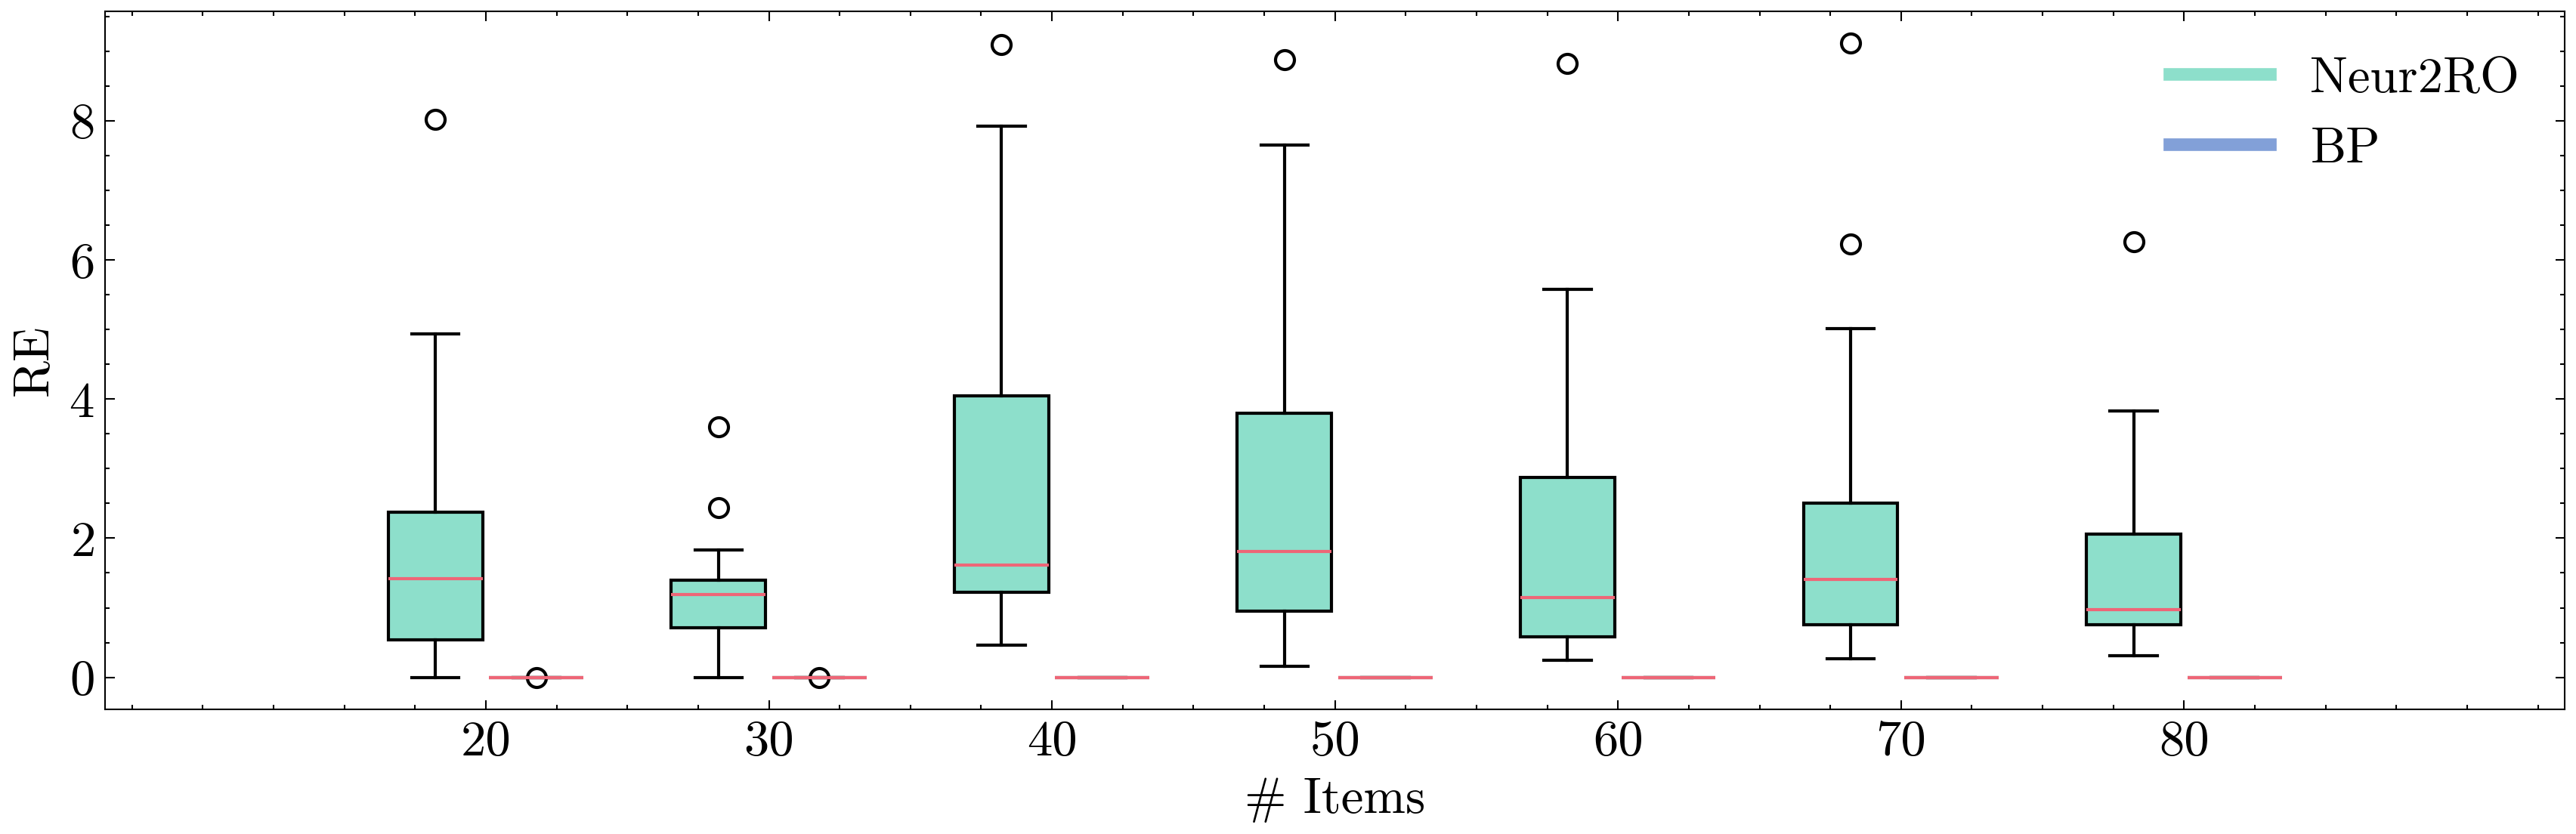

In [30]:
boxplot_for_corr_type("UN")

/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,
/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,


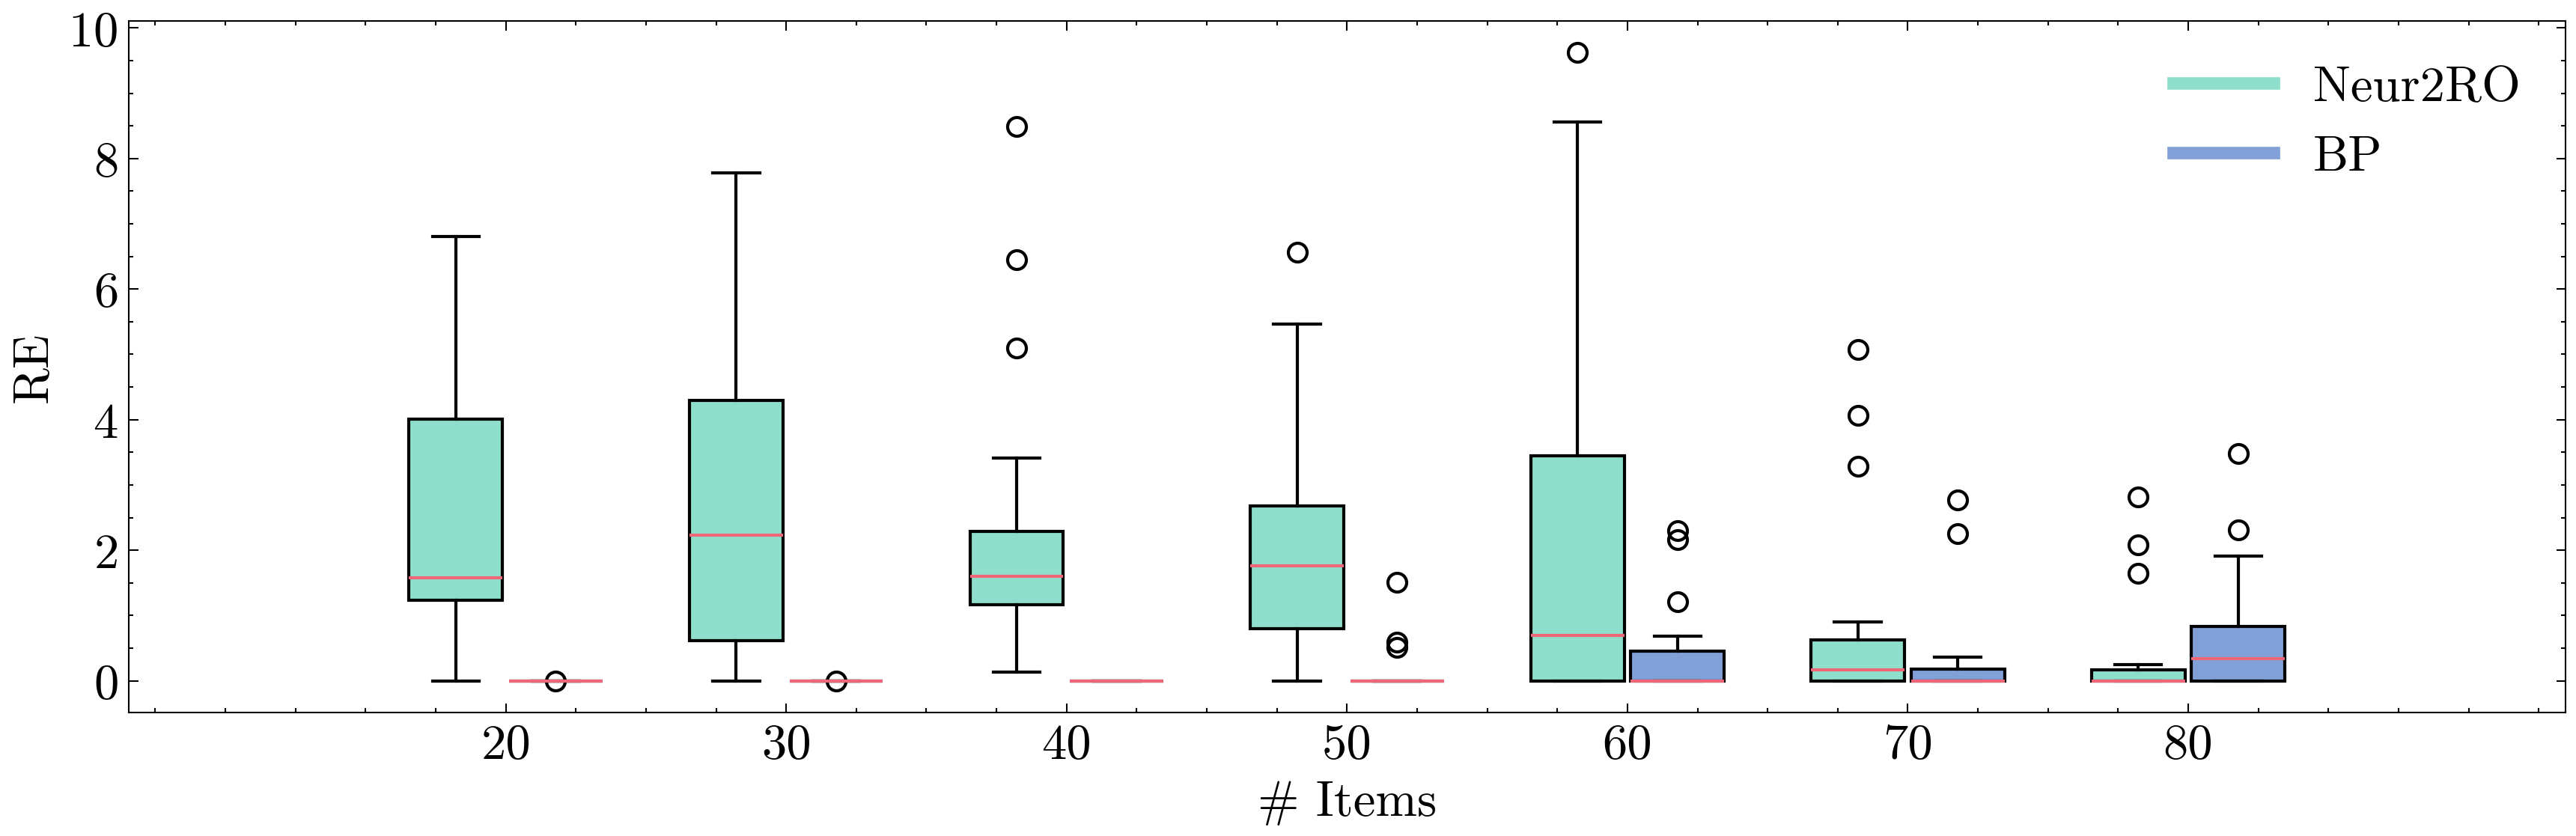

In [32]:
boxplot_for_corr_type("WC")

/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,
/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,


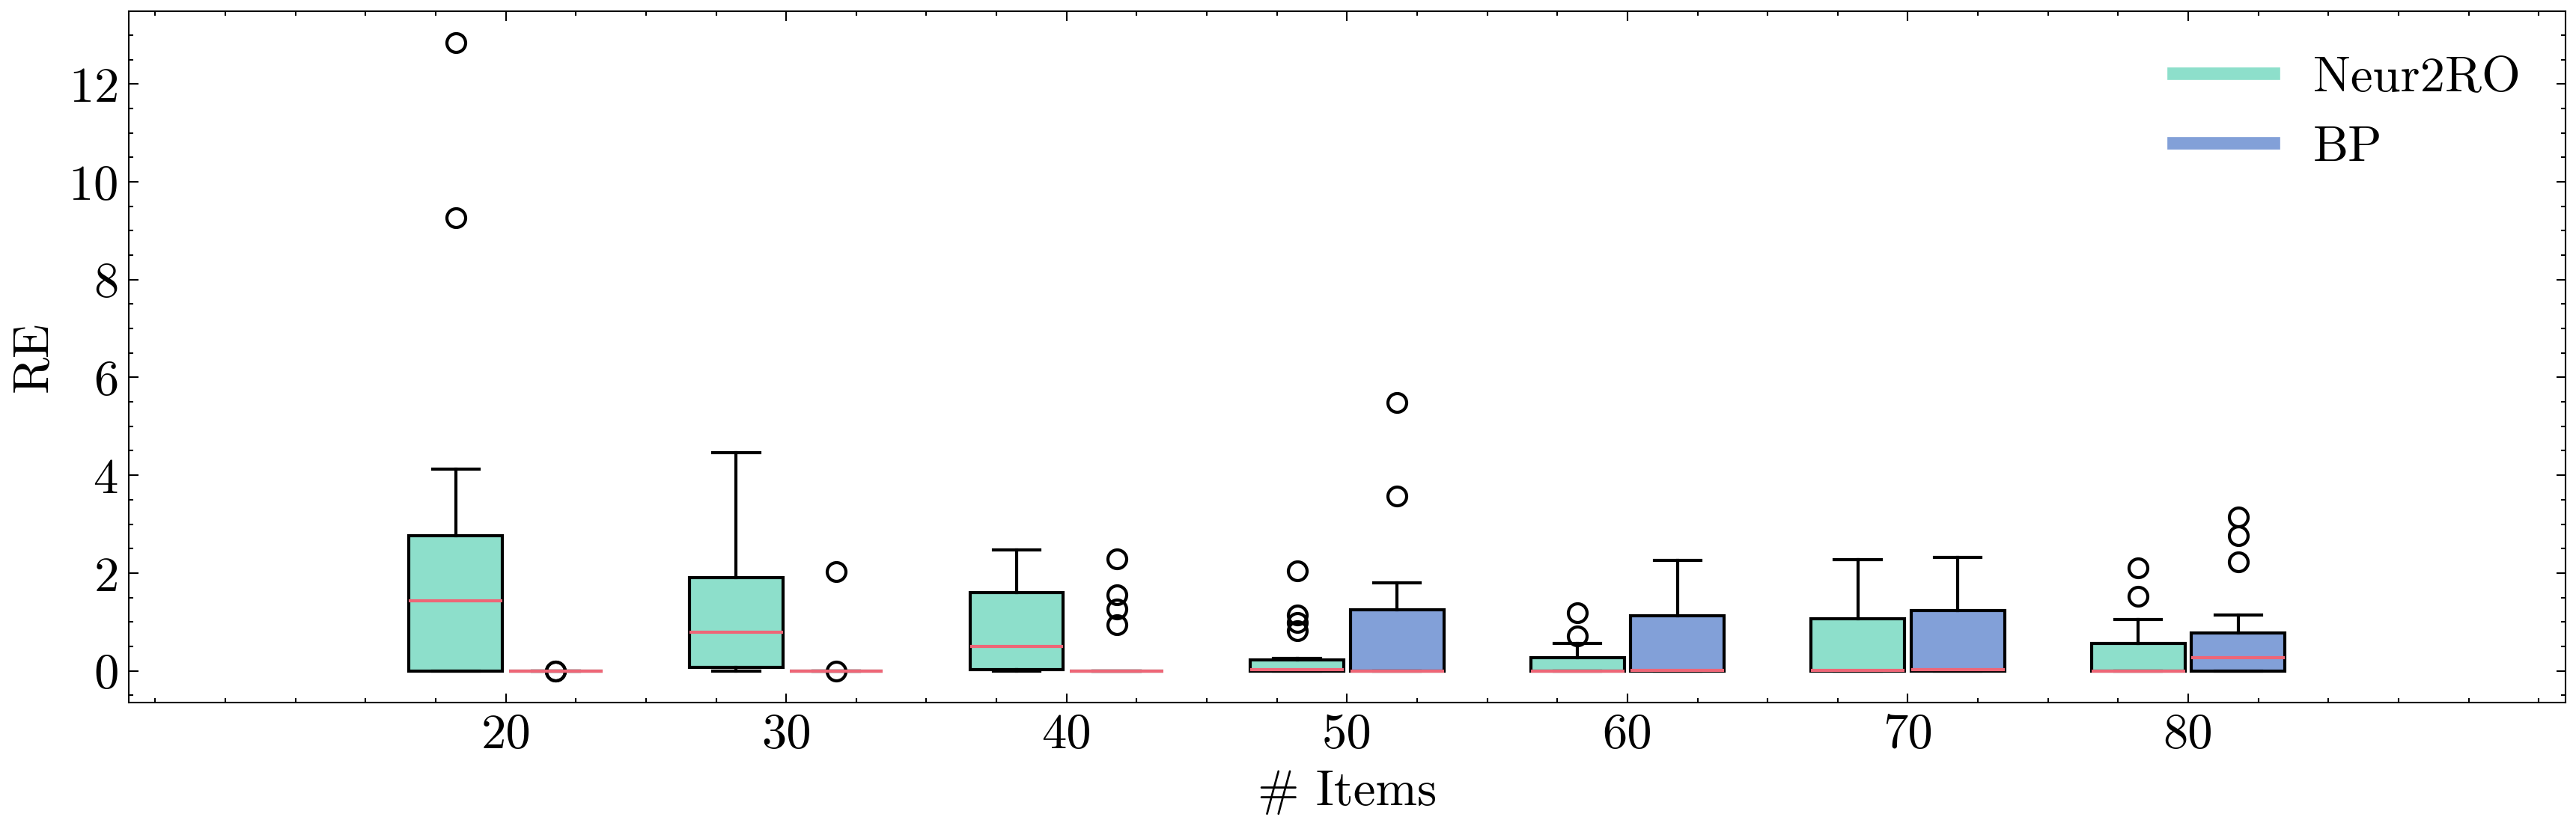

In [33]:
boxplot_for_corr_type("ASC")

/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,
/tmp/ipython-input-1415780292.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax.boxplot(dg,


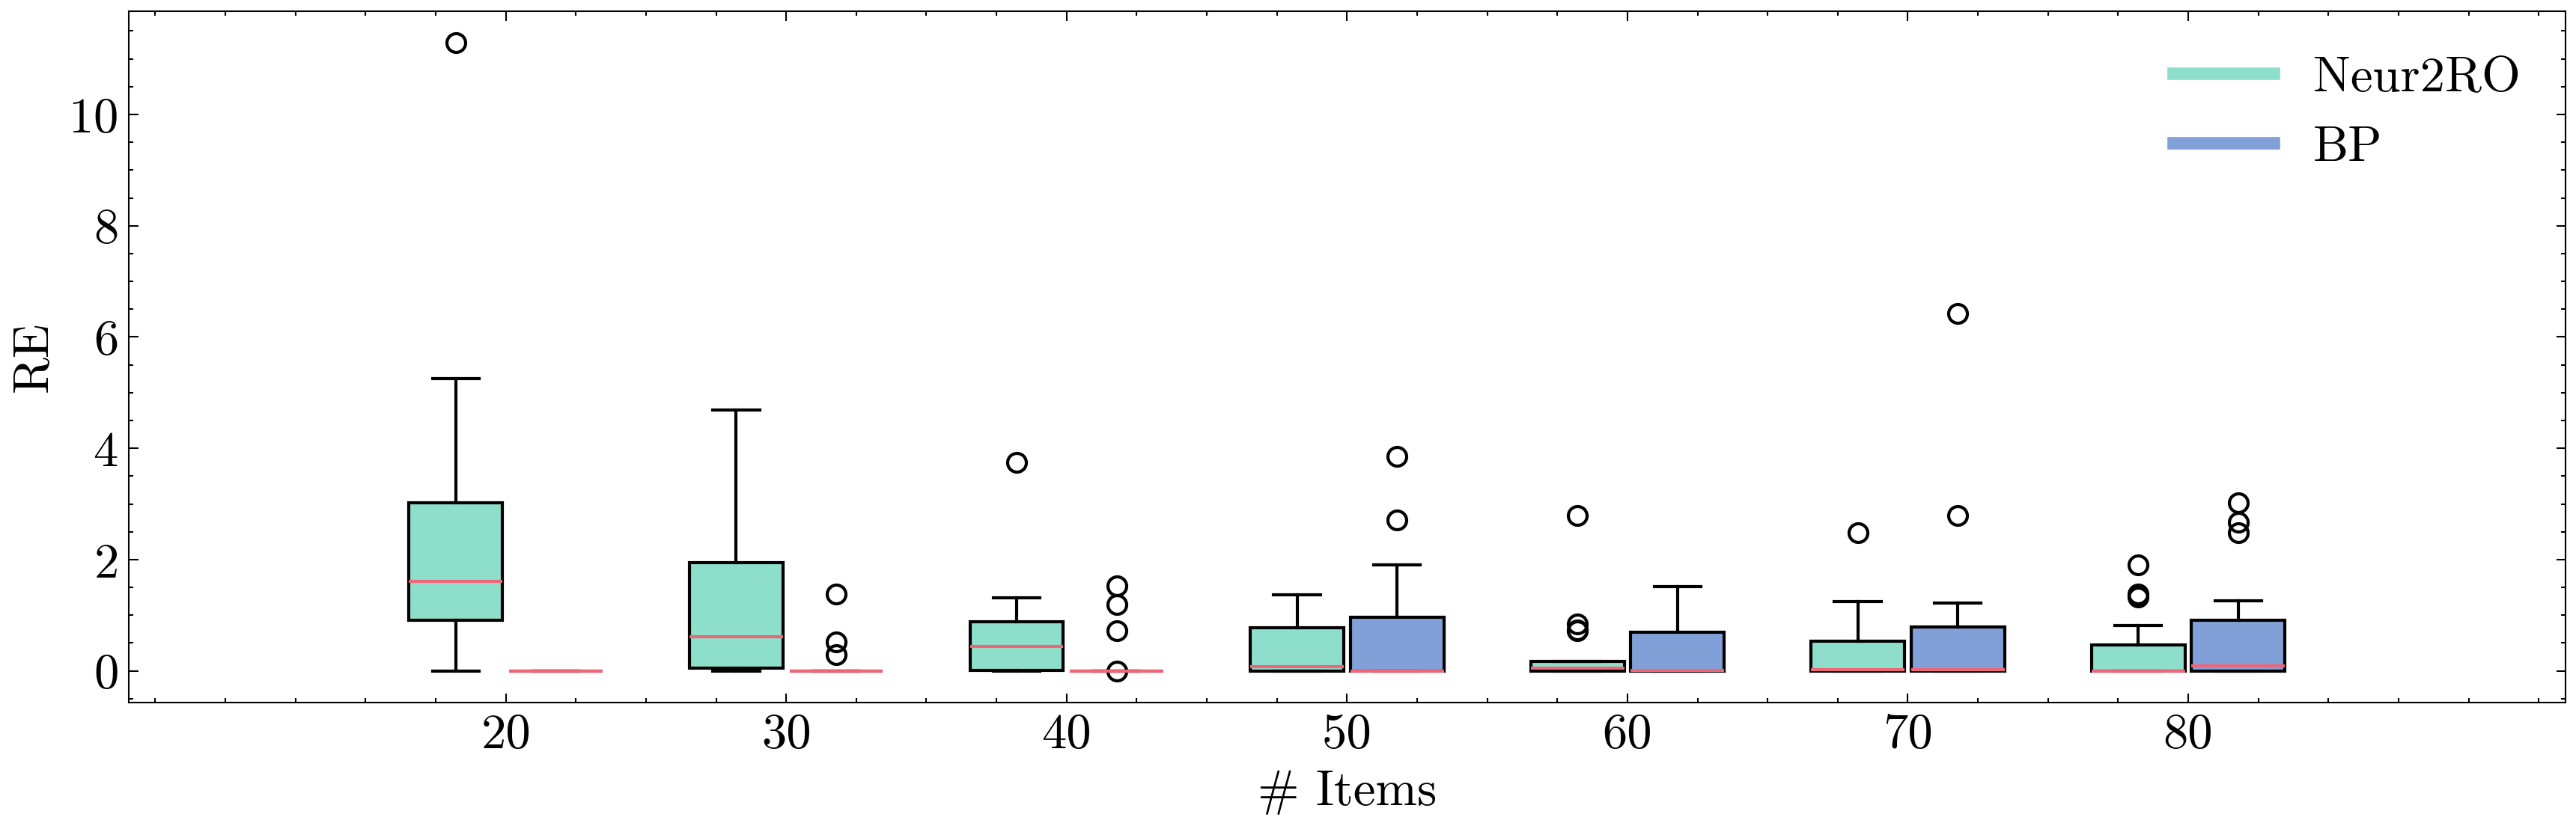

In [31]:
boxplot_for_corr_type("SC")

# Appendix: Tables for distributional information

In [34]:
mp_un = get_main_paper_df_extended(results, 'UN', 'A-AM')
mp_wc = get_main_paper_df_extended(results, 'WC', 'A-AM')
mp_asc = get_main_paper_df_extended(results, 'ASC', 'A-AM')
mp_sc = get_main_paper_df_extended(results, 'SC', 'A-AM')

/tmp/ipython-input-372502469.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["mean-re-ml"][n_item] = n_item_res['re_ml_mean']
/tmp/ipython-input-372502469.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 

In [35]:
latex_main_results_extended(mp_un)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.005 & \textbf{0.000} & 1.417 & \textbf{0.000} & 0.541 & \textbf{0.000} & 2.379 & \textbf{0.000} \\
30 & 1.189 & \textbf{0.000} & 1.188 & \textbf{0.000} & 0.712 & \textbf{0.000} & 1.399 & \textbf{0.000} \\
40 & 2.895 & \textbf{0.000} & 1.614 & \textbf{0.000} & 1.221 & \textbf{0.000} & 4.042 & \textbf{0.000} \\
50 & 3.032 & \textbf{0.000} & 1.814 & \textbf{0.000} & 0.946 & \textbf{0.000} & 3.801 & \textbf{0.000} \\
60 & 2.099 & \textbf{0.000} & 1.146 & \textbf{0.000} & 0.577 & \textbf{0.000} & 2.872 & \textbf{0.000} \\
70 & 2.214 & \textbf{0.000} & 1.408 & \textbf{0.000} & 0.761 & \textbf{0.000} & 2.506 & \textbf{0.000} \\
80 & 1.591 & \textbf{0.000} & 0.968 & \textbf{0.000} & 0.758 & \textbf{0.000} & 2.063 & \textbf{0.000} \\
\bottomrule
\end{tabular

In [36]:
latex_main_results_extended(mp_wc)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.569 & \textbf{0.000} & 1.582 & \textbf{0.000} & 1.229 & \textbf{0.000} & 4.010 & \textbf{0.000} \\
30 & 2.664 & \textbf{0.000} & 2.236 & \textbf{0.000} & 0.616 & \textbf{0.000} & 4.293 & \textbf{0.000} \\
40 & 2.320 & \textbf{0.000} & 1.595 & \textbf{0.000} & 1.164 & \textbf{0.000} & 2.292 & \textbf{0.000} \\
50 & 2.183 & \textbf{0.145} & 1.757 & \textbf{0.000} & 0.793 & \textbf{0.000} & 2.674 & \textbf{0.000} \\
60 & 2.165 & \textbf{0.390} & 0.695 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & 3.445 & \textbf{0.458} \\
70 & 0.884 & \textbf{0.338} & 0.165 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & 0.623 & \textbf{0.175} \\
80 & \textbf{0.392} & 0.691 & \textbf{0.000} & 0.341 & \textbf{0.000} & \textbf{0.000} & \textbf{0.165} & 0.831 

In [37]:
latex_main_results_extended(mp_asc)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.355 & \textbf{0.000} & 1.439 & \textbf{0.000} & 0.000 & \textbf{0.000} & 2.757 & \textbf{0.000} \\
30 & 1.166 & \textbf{0.113} & 0.782 & \textbf{0.000} & 0.075 & \textbf{0.000} & 1.911 & \textbf{0.000} \\
40 & 0.825 & \textbf{0.335} & 0.497 & \textbf{0.000} & 0.019 & \textbf{0.000} & 1.606 & \textbf{0.000} \\
50 & \textbf{0.314} & 0.884 & 0.019 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.229} & 1.251 \\
60 & \textbf{0.197} & 0.523 & \textbf{0.000} & 0.016 & \textbf{0.000} & \textbf{0.000} & \textbf{0.268} & 1.129 \\
70 & \textbf{0.551} & 0.615 & \textbf{0.017} & 0.031 & \textbf{0.000} & \textbf{0.000} & \textbf{1.058} & 1.227 \\
80 & \textbf{0.388} & 0.694 & \textbf{0.000} & 0.265 & \textbf{0.000} & \textbf{0.000} & \textbf{0.554}

In [38]:
latex_main_results_extended(mp_sc)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.387 & \textbf{0.000} & 1.604 & \textbf{0.000} & 0.905 & \textbf{0.000} & 3.018 & \textbf{0.000} \\
30 & 1.068 & \textbf{0.121} & 0.610 & \textbf{0.000} & 0.054 & \textbf{0.000} & 1.939 & \textbf{0.000} \\
40 & 0.658 & \textbf{0.191} & 0.443 & \textbf{0.000} & 0.002 & \textbf{0.000} & 0.888 & \textbf{0.000} \\
50 & \textbf{0.411} & 0.648 & 0.073 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.780} & 0.963 \\
60 & \textbf{0.322} & 0.367 & 0.042 & \textbf{0.010} & \textbf{0.000} & \textbf{0.000} & \textbf{0.173} & 0.693 \\
70 & \textbf{0.389} & 0.738 & \textbf{0.020} & 0.027 & \textbf{0.000} & \textbf{0.000} & \textbf{0.535} & 0.793 \\
80 & \textbf{0.364} & 0.649 & \textbf{0.000} & 0.090 & \textbf{0.000} & \textbf{0.000} & \textbf{0.464}

# Appendix:  Ablation

In [39]:
def get_results_appendix(result_dir, algo_type):
    """ Gets results for specific algorithm type from specified directory.  """
    opt_type, obj_type = algo_type.split("-")

    # filter files for files for algorithm type
    files = os.listdir(result_dir)
    files = list(filter(lambda x: 'results' in x, files))

    if opt_type == "A":
        files = list(filter(lambda x: 'opt-adversarial' in x, files))
    elif opt_type == "S":
        files = list(filter(lambda x: 'opt-sampling' in x, files))

    if obj_type == "AM":
        files = list(filter(lambda x: 'obj-argmax' in x, files))
    elif obj_type == "M":
        files = list(filter(lambda x: 'obj-max' in x, files))

    # append directory
    files = list(map(lambda x: result_dir + x, files))

    # load results for all files
    results = {}
    for n_items in [20,30,40,50,60,70,80]:
        results[n_items] = []

    for file in files:
        with open(file, 'rb') as p:
            file_res = pkl.load(p)
            n_items = len(file_res['opt_stats']['sols'][-1])
            results[n_items].append(file_res)

    return results

In [40]:
def replace_none_with_0(l):
    new_l = []
    for item in l:
        if item is None:
            new_l.append(0)
        else:
            new_l.append(item)
    return new_l

In [41]:
def fix_baseline_time(l):
    """ Converts to floats and TIME_LIMIT to 3 hours.  """
    new_l = []
    for item in l:
        if item == 'TIME_LIMIT':
            new_l.append(10800)
        else:
            new_l.append(float(item))
    return new_l

In [42]:
def get_df_for_type(results, inst_type, algo_type):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = [f"gap-{algo_type}", f"mre-{algo_type}", "mre-baseline", f"time-{algo_type}", "Mean Time Baseline", "# Timeouts Baseline", "# Instances", "# Scenarios Added"]

    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)

        df[f"gap-{algo_type}"][n_item] = n_item_res['mean_gap']
        df[f"mre-{algo_type}"][n_item] = n_item_res['mre_ml_mean']
        df[f"mre-baseline"][n_item] = n_item_res['mre_baseline_mean']
        df[f"time-{algo_type}"][n_item] = n_item_res['mean_time_algo']
        df["Mean Time Baseline"][n_item] = n_item_res['mean_time_baseline']
        df["# Timeouts Baseline"][n_item] = n_item_res['n_limits']
        df["# Instances"][n_item] = len(n_item_res['gap'])
        df["# Scenarios Added"][n_item] = n_item_res['n_scenarios']

    return df

In [43]:
def get_abaliation_dict(results_am, results_comp, use_baseline=False, use_median=True):
    comp_results = {}

    for corr_type in ["UN", "WC", "ASC", "SC"]:
        comp_results[corr_type] = {}

        for n_items in cfg.n_items:


            res_am = list(filter(lambda x: corr_type in x['inst_name'], results_am[n_items]))
            res_comp = list(filter(lambda x: corr_type in x['inst_name'], results_comp[n_items]))

            res_am = sorted(res_am, key=lambda x: x['inst_name'])
            res_comp = sorted(res_comp, key=lambda x: x['inst_name'])

            obj_baseline = list(map(lambda x: x['baseline_obj'], res_am))
            obj_baseline = list(map(lambda x: float(x), obj_baseline))
            obj_am = list(map(lambda x: x['algo_obj'], res_am))
            obj_comp = list(map(lambda x: x['algo_obj'], res_comp))
            obj_comp = replace_none_with_0(obj_comp)

            best_known = []

            for i in range(len(obj_baseline)):
                if use_baseline:
                    best_known.append(max(obj_baseline[i], obj_am[i], obj_comp[i]))
                else:
                    best_known.append(max(obj_am[i], obj_comp[i]))

            re_baseline = list(map(lambda x, y: 100 * abs(x - y)/y, obj_baseline, best_known))
            re_am = list(map(lambda x, y: 100 * abs(x - y)/y, obj_am, best_known))
            re_comp = list(map(lambda x, y: 100 * abs(x - y)/y, obj_comp, best_known))

            time_baseline = list(map(lambda x: x['baseline_time'], res_am))
            time_baseline = fix_baseline_time(time_baseline)
            time_am = list(map(lambda x: x['algo_time'], res_am))
            time_comp = list(map(lambda x: x['algo_time'], res_comp))


            if use_median:
                mre_am = np.median(re_am)
                mre_comp = np.median(re_comp)
            else:
                mre_am = np.mean(re_am)
                mre_comp = np.mean(re_comp)

            comp_results[corr_type][n_items] = {
                'mre_am' : mre_am,
                'mre_comp' : mre_comp,

                'time_am' : np.mean(time_am),
                'time_comp' : np.mean(time_comp),
            }

            if use_baseline:
                if use_median:
                    comp_results[corr_type][n_items]['mre_baseline'] = np.median(mre_baseline)
                else:
                    comp_results[corr_type][n_items]['mre_baseline'] = np.mean(mre_baseline)

                comp_results[corr_type][n_items]['time_baseline'] = np.mean(time_baseline)

    return comp_results

In [44]:
def get_df_for_type(results, inst_type, algo_type):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = [f"gap-{algo_type}", f"mre-{algo_type}", "mre-baseline", f"time-{algo_type}", "Mean Time Baseline", "# Timeouts Baseline", "# Instances", "# Scenarios Added"]

    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)

        df[f"gap-{algo_type}"][n_item] = n_item_res['mean_gap']
        df[f"mre-{algo_type}"][n_item] = n_item_res['mre_ml_mean']
        df[f"mre-baseline"][n_item] = n_item_res['mre_baseline_mean']
        df[f"time-{algo_type}"][n_item] = n_item_res['mean_time_algo']
        df["Mean Time Baseline"][n_item] = n_item_res['mean_time_baseline']
        df["# Timeouts Baseline"][n_item] = n_item_res['n_limits']
        df["# Instances"][n_item] = len(n_item_res['gap'])
        df["# Scenarios Added"][n_item] = n_item_res['n_scenarios']

    return df

In [45]:
def get_df_for_type(results, inst_type, algo_type):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = [f"gap-{algo_type}", f"mre-{algo_type}", "mre-baseline", f"time-{algo_type}", "Mean Time Baseline", "# Timeouts Baseline", "# Instances", "# Scenarios Added"]

    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)

        df[f"gap-{algo_type}"][n_item] = n_item_res['mean_gap']
        df[f"mre-{algo_type}"][n_item] = n_item_res['mre_ml_mean']
        df[f"mre-baseline"][n_item] = n_item_res['mre_baseline_mean']
        df[f"time-{algo_type}"][n_item] = n_item_res['mean_time_algo']
        df["Mean Time Baseline"][n_item] = n_item_res['mean_time_baseline']
        df["# Timeouts Baseline"][n_item] = n_item_res['n_limits']
        df["# Instances"][n_item] = len(n_item_res['gap'])
        df["# Scenarios Added"][n_item] = n_item_res['n_scenarios']

    return df

In [46]:
def latex_abilaton_df(df_, am_repl, comp_repl):
    """ Generate Latex table for abilation tables.  """

    df = df_.copy()

    df = df.rename(columns={
        'mre_am' : f'{am_repl}',
        'mre_comp' : f'{comp_repl}',
        'time_am' : f'{am_repl}\ ',
        'time_comp' : f'{comp_repl}\ ',
       })

    #df = df.style.format(thousands=',', precision=2)

    df = df.style.format(thousands=',', formatter =
        {f'{am_repl}'     : '{:.3f}'.format,
         f'{comp_repl}'   : '{:.3f}'.format,
         f'{am_repl}\ '   : '{:.0f}'.format,
         f'{comp_repl}\ ' : '{:.0f}'.format,
        })

    df = df.highlight_min(subset=[f'{am_repl}', f'{comp_repl}'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=[f'{am_repl}\ ', f'{comp_repl}\ '], props='textbf:--rwrap;', axis=1)

    end_str = '}\n\\caption{todo}\n'
    end_str += '\\label{tab:todo}\n'
    end_str += '\\end{table*}'

    latex_str = df.to_latex(column_format='l|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, '\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:29: SyntaxWarning: invalid escape sequence '\_'
<>:29: SyntaxWarning: invalid escape sequence '\#'
<>:33: SyntaxWarning: invalid escape sequence '\#'
<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:29: SyntaxWarning: invalid escape sequence '\_'
<>:29: SyntaxWarning: invalid escape sequence '\#'
<>:33: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipython-input-3781067986.py:9: SyntaxWarning: invalid escape sequence '\ '
  't

## Appendix Tables: Argmax vs Max

In [47]:
result_dir_appendix = data_dir + problem + '/appendix_results/'

In [48]:
result_dir_appendix

'/content/drive/MyDrive/Neur2RO/data/kp/appendix_results/'

In [49]:
algo_type = "A-AM"
results_am = get_results_appendix(result_dir_appendix, algo_type)

In [50]:
algo_type = "A-M"
results_m = get_results_appendix(result_dir_appendix, algo_type)

In [51]:
comp_results = get_abaliation_dict(results_am, results_m, use_median=True)

In [52]:
latex_abilaton_df(pd.DataFrame(comp_results['UN']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 1.167 & \textbf{5} & 11 \\
30 & \textbf{0.000} & 0.945 & \textbf{7} & 14 \\
40 & \textbf{0.000} & 1.931 & \textbf{9} & 24 \\
50 & \textbf{0.000} & 1.634 & \textbf{10} & 33 \\
60 & \textbf{0.000} & 0.452 & \textbf{17} & 29 \\
70 & \textbf{0.000} & 0.801 & \textbf{19} & 28 \\
80 & \textbf{0.000} & 2.227 & \textbf{13} & 35 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [53]:
latex_abilaton_df(pd.DataFrame(comp_results['WC']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 3.515 & \textbf{6} & 13 \\
30 & \textbf{0.000} & 2.405 & \textbf{11} & 22 \\
40 & \textbf{0.000} & 0.502 & \textbf{26} & 42 \\
50 & \textbf{0.000} & 0.254 & \textbf{24} & 39 \\
60 & \textbf{0.000} & 1.528 & 77 & \textbf{58} \\
70 & \textbf{0.000} & 1.769 & \textbf{18} & 35 \\
80 & \textbf{0.000} & 3.492 & \textbf{27} & 75 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [54]:
latex_abilaton_df(pd.DataFrame(comp_results['ASC']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 2.042 & \textbf{5} & 12 \\
30 & \textbf{0.000} & 1.433 & \textbf{6} & 14 \\
40 & \textbf{0.000} & 1.739 & \textbf{11} & 33 \\
50 & \textbf{0.000} & 3.161 & \textbf{8} & 20 \\
60 & \textbf{0.000} & 2.449 & \textbf{15} & 30 \\
70 & \textbf{0.000} & 2.497 & \textbf{18} & 35 \\
80 & \textbf{0.000} & 1.824 & \textbf{17} & 30 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [55]:
latex_abilaton_df(pd.DataFrame(comp_results['SC']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 1.154 & \textbf{5} & 11 \\
30 & \textbf{0.000} & 0.967 & \textbf{7} & 15 \\
40 & \textbf{0.000} & 1.928 & \textbf{16} & 28 \\
50 & \textbf{0.000} & 3.613 & \textbf{10} & 21 \\
60 & \textbf{0.000} & 2.005 & \textbf{20} & 26 \\
70 & \textbf{0.000} & 2.657 & \textbf{16} & 33 \\
80 & \textbf{0.000} & 2.051 & \textbf{16} & 28 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



## Appendix Tables: Adversarial vs Sampling

In [56]:
algo_type = "A-AM"
results_am = get_results_appendix(result_dir_appendix, algo_type)

In [57]:
algo_type = "S-AM"
results_s = get_results_appendix(result_dir_appendix, algo_type)

In [58]:
comp_results = get_abaliation_dict(results_am, results_s)

In [59]:
latex_abilaton_df(pd.DataFrame(comp_results['UN']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & \textbf{0.000} & 5 & \textbf{2} \\
30 & \textbf{0.000} & \textbf{0.000} & 7 & \textbf{4} \\
40 & 0.560 & \textbf{0.000} & 9 & \textbf{4} \\
50 & 0.723 & \textbf{0.000} & 10 & \textbf{5} \\
60 & 0.066 & \textbf{0.000} & 17 & \textbf{6} \\
70 & 0.150 & \textbf{0.000} & 19 & \textbf{8} \\
80 & 0.395 & \textbf{0.000} & 13 & \textbf{9} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [60]:
latex_abilaton_df(pd.DataFrame(comp_results['WC']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & 0.074 & 6 & \textbf{3} \\
30 & \textbf{0.000} & 0.444 & 11 & \textbf{4} \\
40 & \textbf{0.000} & 0.093 & 26 & \textbf{5} \\
50 & 0.441 & \textbf{0.000} & 24 & \textbf{7} \\
60 & 0.119 & \textbf{0.065} & 77 & \textbf{9} \\
70 & \textbf{0.000} & 0.185 & 18 & \textbf{8} \\
80 & \textbf{0.000} & 0.536 & 27 & \textbf{9} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [61]:
latex_abilaton_df(pd.DataFrame(comp_results['ASC']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & \textbf{0.000} & 5 & \textbf{2} \\
30 & \textbf{0.000} & 0.402 & 6 & \textbf{4} \\
40 & \textbf{0.000} & 0.663 & 11 & \textbf{5} \\
50 & \textbf{0.000} & 0.587 & 8 & \textbf{6} \\
60 & \textbf{0.000} & 0.690 & 15 & \textbf{8} \\
70 & \textbf{0.000} & 0.111 & 18 & \textbf{8} \\
80 & \textbf{0.000} & 0.827 & 17 & \textbf{9} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [62]:
latex_abilaton_df(pd.DataFrame(comp_results['SC']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & \textbf{0.000} & 5 & \textbf{3} \\
30 & \textbf{0.000} & 0.402 & 7 & \textbf{4} \\
40 & \textbf{0.000} & 0.238 & 16 & \textbf{5} \\
50 & \textbf{0.000} & 0.574 & 10 & \textbf{6} \\
60 & \textbf{0.000} & 0.558 & 20 & \textbf{7} \\
70 & \textbf{0.000} & 0.174 & 16 & \textbf{7} \\
80 & \textbf{0.000} & 0.548 & 16 & \textbf{9} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



# Appendix: Data collection

In [63]:
with open(fp_data, 'rb') as p:
    ml_data = pkl.load(p)

In [64]:
print("Time data collection:", ml_data['total_time'])

Time data collection: 2162.646444797516


# Appendix: Training

In [65]:
with open(fp_nn_res, 'rb') as p:
    tr_res = pkl.load(p)

In [66]:
print("Time (training):", tr_res["train_time"])

Time (training): 9512.993661165237


In [67]:
eps = range(1,500, 10)
tr_maes = list(map(lambda x: x['mae'], tr_res['training_stats']['tr_results']))
val_maes = tr_res['training_stats']['val_maes']

In [68]:
colors = ['#82A0D8', 'r',]
fontsize = 16

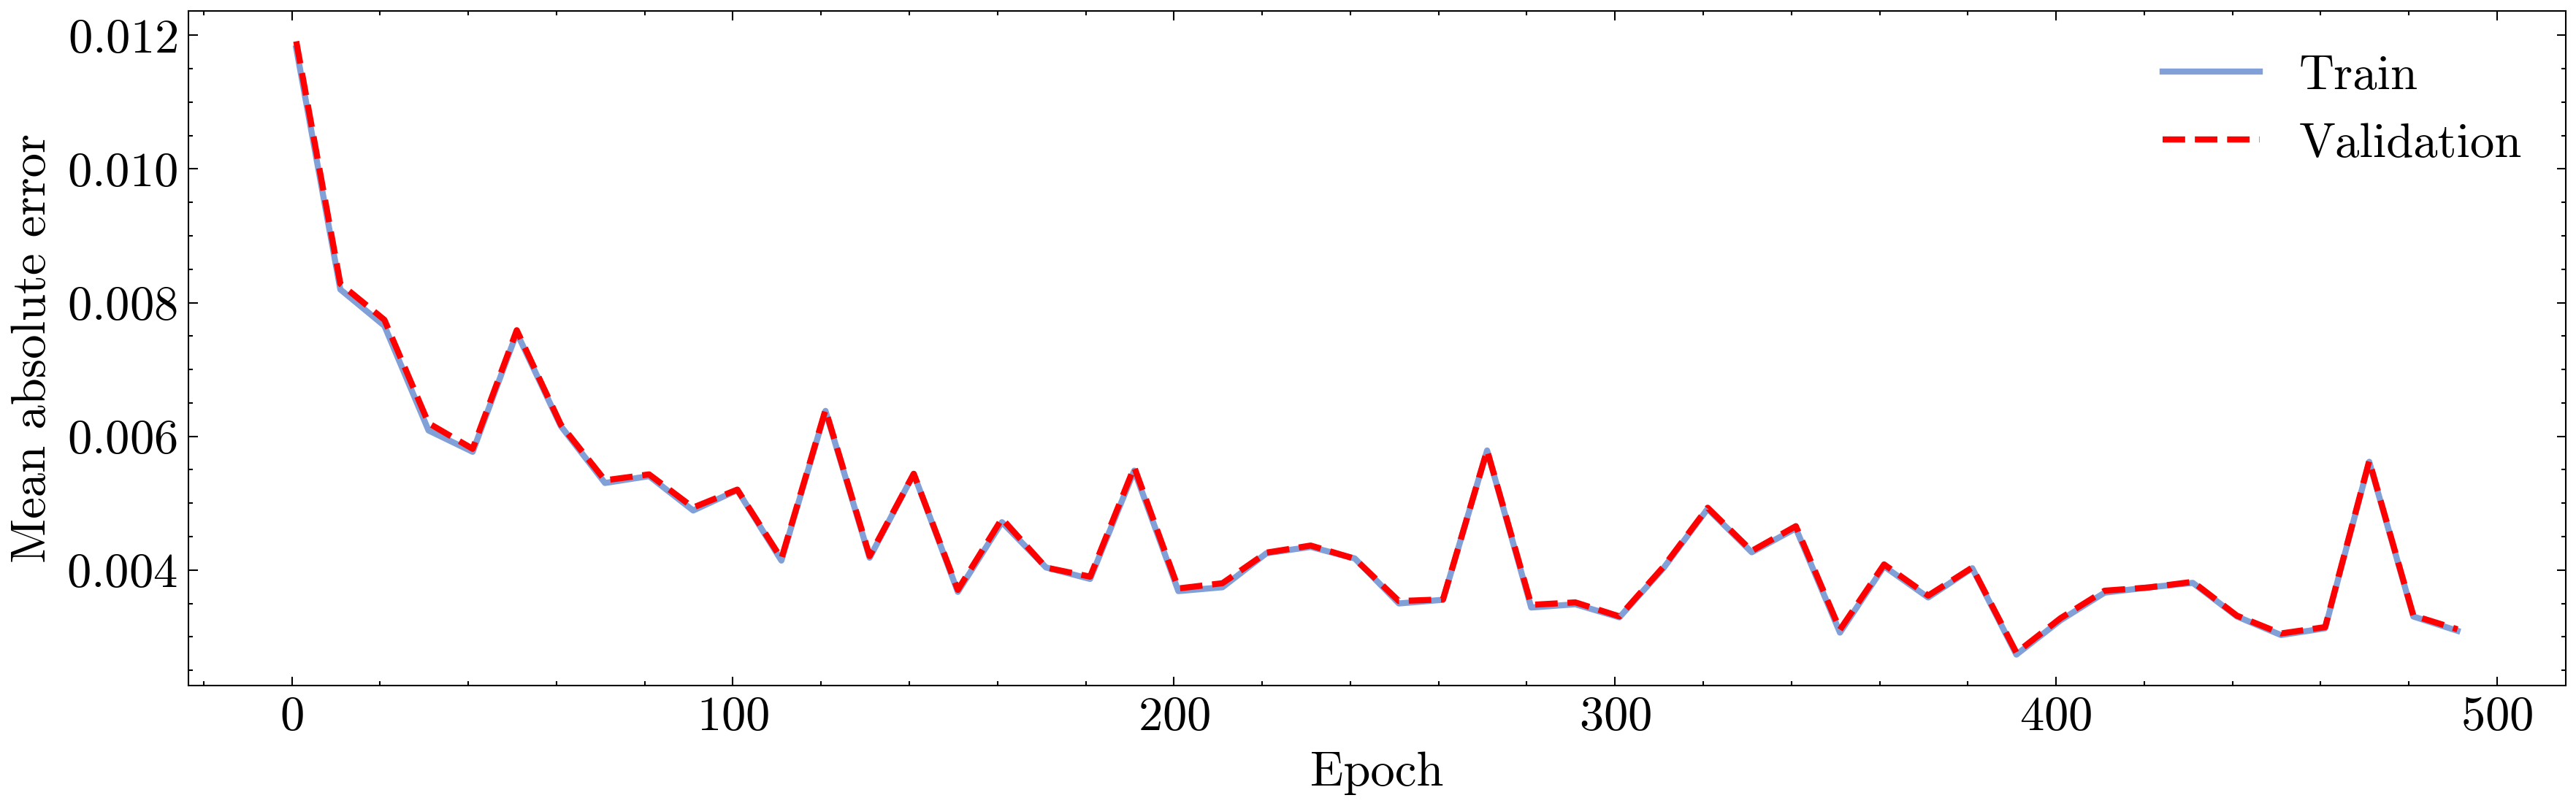

In [71]:
with plt.style.context(['science', 'nature', 'bright', 'no-latex']):

    fig, ax = plt.subplots(figsize=(14,4), dpi=300)

    plt.plot(eps, tr_maes, label = 'Train', color=colors[0], lw=2, alpha=1)
    plt.plot(eps, val_maes, label = 'Validation', color=colors[1], lw=2, alpha=1,linestyle='dashed')

    ax.legend(fontsize=fontsize)
    ax.set_ylabel('Mean absolute error', fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize)

    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)

    plt.show()